<a href="https://colab.research.google.com/github/bootstrap666/compressiveSensingPianoBasis/blob/main/CompSensingpiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from IPython.display import Audio # Utilizada para emitir formas de onda pelo dispositivo de áudio padrão
import pickle

In [3]:
## This file generates a basis from piano note frequencies (plus a few
# more). We will use this as the basis for our songs during l1-minimization routines.

fs=44100           # Sampling frequency
t = np.arange(1/fs,0.25,1/fs) # Time points of each sample in a quarter-second note
T = len(t)      # Number of samples in a note
M = 29             # Number of notes in Mary Had a Little Lamb.

# The frequencies for piano notes can be derived from formula.
# I simply downloaded them from Professor Bryan Suits at Michigan Tech.
# http://www.phy.mtu.edu/~suits/notefreqs.html

allfreqs = np.array([16.35, 17.32, 18.35, 19.45, 20.6, 21.83, 23.12, 24.5, \
                     25.96, 27.5, 29.14, 30.87, 32.7, 34.65, 36.71, 38.89, \
                     41.2, 43.65, 46.25, 49, 51.91, 55, 58.27, 61.74, 65.41, \
                     69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, \
                     110, 116.54, 123.47, 130.81, 138.59, 146.83, 155.56, \
                     164.81, 174.61, 185, 196, 207.65, 220, 233.08, 246.94, \
                     261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, \
                     392, 415.3, 440, 466.16, 493.88, 523.25, 554.37, 587.33, 
                     622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880, \
                     932.33, 987.77, 1046.5, 1108.73, 1174.66, 1244.51, \
                     1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760, \
                     1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, \
                     2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520, \
                     3729.31, 3951.07, 4186.01, 4434.92, 4698.64, 4978.03])



In [4]:
## First let's generate the scale so we can hear what the notes will sound
# like.

xall=np.zeros((len(t),len(allfreqs))) # This vector will hold all our notes.

# I multiply the sine waves by exponentials to get a "ding" sound:
df = 15 # This is the rate of decay of the note.
sf = 15 # This is the rate of growth at the beginning of the note.

for i in range(len(allfreqs)):
    xall[:,i] = (1+np.exp(-df*t[len(t)-1])-np.exp(-sf*t))*np.exp(-df*t)*np.sin(2*np.pi*allfreqs[i]*t)


# Play the whole scale to hear what it sounds like:
x=np.zeros(len(t)*len(allfreqs)) # This vector will hold all our notes.

for i in range(len(allfreqs)):
  x[i*len(t):(i+1)*len(t)] = xall[:,i]

Audio(x,rate=fs)
  #sound(xall[:,i],fs)


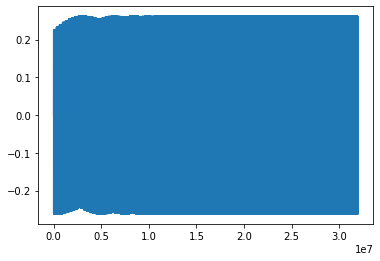

In [5]:
## Now let's create a basis that we will use to reconstruct songs.
# All notes will be a quarter-second long, and our basis will handle 
# 29-note songs. So we simply need to replicate each note in each position 
# in the song.

# Since there will be a lot of zeros, we will use the sparse matrix format 
# for efficient computation.

I=np.zeros(len(t)*len(allfreqs)*M) # Row indices
J=np.zeros(len(t)*len(allfreqs)*M) # Column indices
S=np.zeros(len(t)*len(allfreqs)*M) # The matrix value at that index.
inds=range(len(t))
biter=0 #biter = 1
for fiter in range(len(allfreqs)):
    for k in range(M):
        I[inds] = np.array([np.ones(len(t))*biter])
        J[inds] = range(k*T,(k+1)*T)
        S[inds] = [(1+np.exp(-df*t[len(t)-1])-np.exp(-sf*t))*np.exp(-df*t)*np.sin(2*np.pi*allfreqs[fiter]*t)]
        biter=biter+1
        #inds = inds+len(t)
        inds = range((fiter*M + k-1)*T,(fiter*M + k)*T)
    
plt.plot(S)
Audio(S[range(M*T)],rate=fs)
#tic
#  pianoBasis = sparse(I,J,S,length(allfreqs)*M,M*T)
#toc

#save pianoBasis.mat pianoBasis fs t M allfreqs


In [10]:
pianoBasis = sparse.csr_matrix((S, (I, J)), shape = (biter, M*T)) #.toarray()

with open('pianoBasis.pkl', 'wb') as f:  
    pickle.dump([pianoBasis, fs, t, M, allfreqs], f)